In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import time
from tqdm import tqdm_notebook as tqdm
import itertools

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using %s for computation" % device)

Using cuda for computation


In [3]:
project_dir = ''
dataset_dir = project_dir + 'celebA/'
images_dir = project_dir + 'images/'
model_dir = project_dir + 'models/'

In [4]:
batch_size = 32           # number of inputs in each batch
epochs = 2               # times to run the model on complete data
image_size = 64
hidden_size = 1024        # hidden dimension
latent_size = 128          # latent vector dimension
lr = 1e-3                 # learning rate
train_loss = []

In [ ]:
# !apt-get install p7zip-full

In [ ]:
# !7z e /content/gdrive/My\ Drive/datasets/resized_celebA.zip -o/content/gdrive/My\ Drive/datasets/celebA/

In [5]:
class CelebDataset(Dataset):
    def __init__(self, root_dir, split=None, selected_attr=None, transform=None):

        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images/')
        self.attr_dir = os.path.join(root_dir, 'list_attr_celeba.csv')
        self.partition_dir = os.path.join(root_dir, 'list_eval_partition.csv')
        self.transform = transform
        self.selected_attr = selected_attr
        self.split = split
        self.preprocess()

    def preprocess(self):
        if self.selected_attr is None:
            self.num_attr = 40
            self.attr = pd.read_csv(self.attr_dir)
        else:
            self.num_attr = len(self.selected_attr)
            self.image_ids = pd.read_csv(self.attr_dir)["image_id"]
            self.attr = pd.read_csv(self.attr_dir)[self.selected_attr]

        # self.attr.replace(to_replace=-1, value=0, inplace=True)
        if self.split is not None:
            partition = pd.read_csv(self.partition_dir)
            if self.split == 'train':
                self.attr = self.attr[partition.partition == 0]
            elif self.split == 'valid':
                self.attr = self.attr[partition.partition == 1]
            elif self.split == 'test':
                self.attr = self.attr[partition.partition == 2]

        self.attr = self.attr.values.astype(np.float32)

    def __len__(self):
        return len(self.attr)

    def __getitem__(self, idx):
        name = self.image_ids[idx]
        image = Image.open(os.path.join(self.root_dir, 'images', name))
        img_attr = self.attr[idx]
        if self.transform is not None:
            image = self.transform(image)

        return image, img_attr

In [6]:
all_columns = '5_o_Clock_Shadow	Arched_Eyebrows	Attractive	Bags_Under_Eyes	Bald	Bangs	Big_Lips	Big_Nose	Black_Hair	Blond_Hair	Blurry	Brown_Hair	Bushy_Eyebrows	Chubby	Double_Chin	Eyeglasses	Goatee	Gray_Hair	Heavy_Makeup	High_Cheekbones	Male	Mouth_Slightly_Open	Mustache	Narrow_Eyes	No_Beard	Oval_Face	Pale_Skin	Pointy_Nose	Receding_Hairline	Rosy_Cheeks	Sideburns	Smiling	Straight_Hair	Wavy_Hair	Wearing_Earrings	Wearing_Hat	Wearing_Lipstick	Wearing_Necklace	Wearing_Necktie	Young'
all_columns.split('\t')
columns = 'Black_Hair	Blond_Hair	Brown_Hair	Male	No_Beard	Smiling	Straight_Hair	Wavy_Hair	Young'
columns = columns.split('\t')
num_columns = len(columns)

9

In [7]:
train_data = CelebDataset(root_dir=dataset_dir, split='train', selected_attr=columns,
                          transform=transforms.Compose([transforms.ToTensor()]))
valid_data = CelebDataset(root_dir=dataset_dir, split='valid', selected_attr=columns, transform=transforms.Compose([transforms.ToTensor()]))
test_data = CelebDataset(root_dir=dataset_dir, split='test', selected_attr=columns, transform=transforms.Compose([transforms.ToTensor()]))

In [8]:
trainloader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=16)
validloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images)

def show_image(img):
    plt.imshow(img.permute(1, 2, 0), interpolation="bicubic")
    plt.show()

In [10]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), 1024, 1, 1)

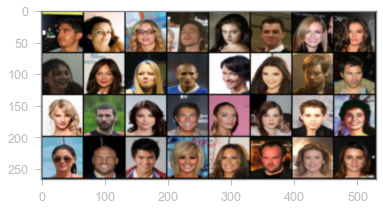

In [11]:
images, attr = next((iter(validloader)))
show_images(images)

In [12]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, image_dim=image_size, hidden_size=hidden_size, latent_size=latent_size, num_classes=num_columns):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, 4, 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2),
            nn.LeakyReLU(0.2),
            Flatten(),
        )
        self.encoder_mean = nn.Linear(hidden_size, latent_size)
        self.encoder_logvar = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(latent_size, latent_size - num_classes)
        self.fc4 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size - num_classes)
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(hidden_size, 128, 5, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 6, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, 6, 2),
            nn.Sigmoid()
        )

    def sample(self, log_var, mean):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def forward(self, x, a):
        x = self.encoder(x)
        x = self.fc1(x)
        x = torch.cat((x, a), 1)
        x = self.fc2(x)

        log_var = self.encoder_logvar(x)
        mean = self.encoder_mean(x)
        z = self.sample(log_var, mean)

        z = self.fc3(z)
        z = torch.cat((z, a), 1)
        x = self.fc4(z)
        x = self.decoder(x)

        return x, mean, log_var


vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)
vae.load_state_dict(torch.load(
    model_dir + "Conditional-VAE.pt", map_location=torch.device(device)))

<All keys matched successfully>

Epoch: 0
Train Loss:
6517.6171875
Reconstructed Images


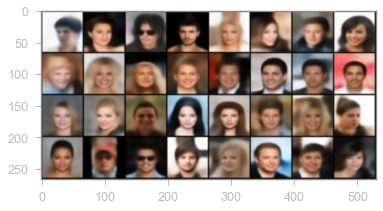

Epoch: 0
Train Loss:
6515.22412109375
Reconstructed Images


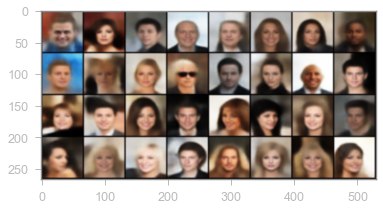

Epoch: 0
Train Loss:
6469.1513671875
Reconstructed Images


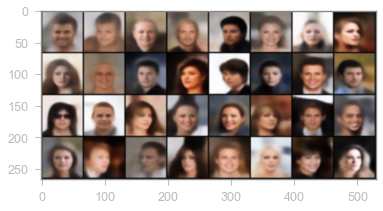

Epoch: 0
Train Loss:
5797.17724609375
Reconstructed Images


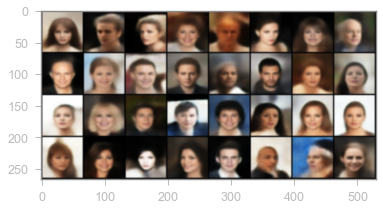

Epoch: 0
Train Loss:
6270.15087890625
Reconstructed Images


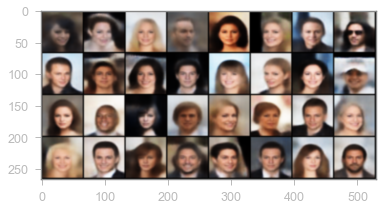

Epoch: 0
Train Loss:
6120.291015625
Reconstructed Images


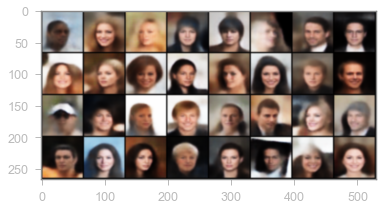

Epoch: 0
Train Loss:
6500.7705078125
Reconstructed Images


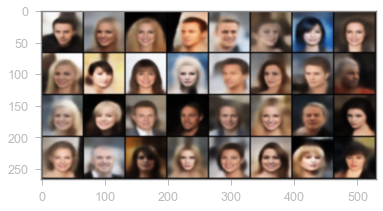

Epoch: 0
Train Loss:
6266.92919921875
Reconstructed Images


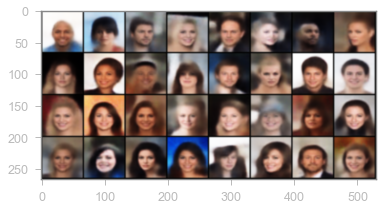

Epoch: 0
Train Loss:
6323.79541015625
Reconstructed Images


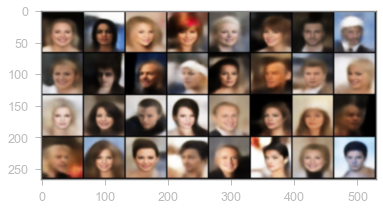

Epoch: 0
Train Loss:
6078.40478515625
Reconstructed Images


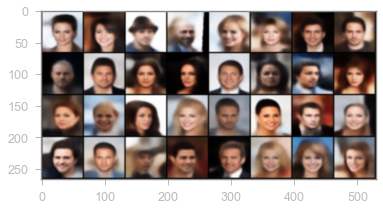

Epoch: 0
Train Loss:
6567.4609375
Reconstructed Images


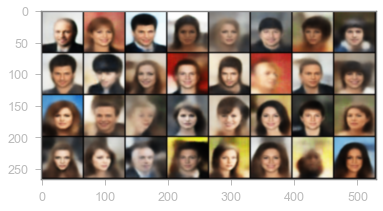

Epoch: 1
Train Loss:
6498.09912109375
Reconstructed Images


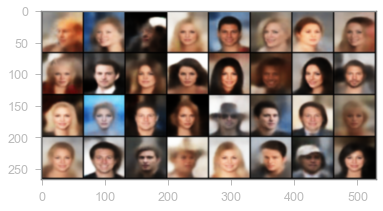

Epoch: 1
Train Loss:
6478.83935546875
Reconstructed Images


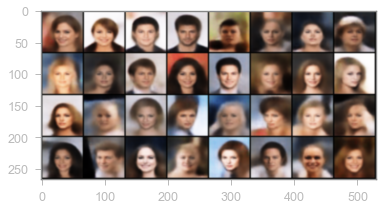

RuntimeError: reduce failed to synchronize: device-side assert triggered

In [13]:
vae.train()
for epoch in range(4):
    for i, (images, attr) in tqdm(enumerate(trainloader), total = len(trainloader)):
        images = images.to(device)
        attr = attr.to(device)
        optimizer.zero_grad()
        reconstructed_image, mean, log_var = vae(images, attr)
        
        CE = F.binary_cross_entropy(
            reconstructed_image, images, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        
        loss = CE + KLD
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item()/len(images))
        
        if(i % 2000 == 0):
            torch.save(vae.state_dict(), model_dir +
                       "Conditional-VAE.pt")
            
        with torch.no_grad():
            if(i % 500 == 0):
                print("Epoch: %d" % epoch)
                print("Train Loss:")
                print(loss.item()/len(images))
                print("Reconstructed Images")
                show_images(reconstructed_image.cpu())

In [ ]:
plt.plot(train_loss)
plt.show()

In [ ]:
torch.save(vae.state_dict(), model_dir+"Conditional-VAE.pt")

In [ ]:
vae.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        images = images.to(device)
        reconstructed_image, mean, log_var = vae(images)
        if(i % 100 == 0):
            show_images(reconstructed_image.cpu())
            img_name = images_dir + 'evaluation/' + str(i).zfill(6) + '.png'
            torchvision.utils.save_image(
                torchvision.utils.make_grid(reconstructed_image), img_name)